# Assignment 1 - k-Armed Bandit Problems

<div class="alert alert-info">

**Due:** 28.10.2021, 15:00

In this assignment, you will implement different strategies (algorithms) to solve the k-Armed Bandit problem, and you will compare and visually analyze their relative performance differences. The maximum number of points for each subtask is indicated next to the sections.

To successfully complete this exercise, read the notebook carefully from beginning to end, and pay special attention to the coding parts marked with **TODO**.
</div>


# Definition of the Problem (Repetition)
k-armed bandit problem definition:
- we repeatly choose among $k$ different actions
- after each action we receive a numeric reward
  (originating from a stationary probability distribution, except in the last exercise in this problem set)
- the sole objective: maximize expected total reward over time (by finding and exploiting the most beneficial actions)

The particular **algorithm testbed** we will be using here is defined as follows:
- a set of 2000 randomly generated $10$-armed bandit problems
- for each problem instance, the true action values $q_*(a)$ are sampled from $\mathcal{N}(0,\,1)$ in the beginning
- the actual rewards $R_t$ are sampled from $\mathcal{N}(q_*(a),\,1)$ at each step
- we **don't know** the true action values, and hence have to **estimate** them!

## Python Imports

In [47]:
import numpy as np
import matplotlib.pyplot as plt

## Definition of k-Armed Bandit Problem
In this section we implement the actual bandit problem.

In [48]:
class kArmedBandit():
    """
    Specifies a k-armed bandit problem
    
    The agent has to choose from k different actions.
    Taking an action yields a numeric reward specified
    by a stationary probability distribution.
    """
    
    def __init__(self, k=10, seed=None):
        """
        Parameters
        ----------
            @k: the number of actions / arms / levers of the k-armed bandit
            @seed: the seed of the pseudo random number generator (PRNG) that
                   completely specifies this (random) k-armed bandit problem.
                   if you use 'None' for the seed, numpy will use the entropy
                   pool of the operating system to get some true randomness.
                   in the interest of having reproducible experiments, we should
                   always provide a seed here.
        """
        self.k = k
        self.rng = np.random.default_rng(seed)
        # sample the true action values from a gaussian
        # with mean 0 and standard deviation 1.
        
        # these are the values we **don't know**!
        # we'll never use them directly!
        self.q_star = self.rng.normal(0, 1, k)
    
    def step(self, action):
        """
        Take one step, choosing 'action'. This is the **only** method
        that the agent will interact with.
        
        Parameters
        ----------
           @action: action id (integer in [0, k[)
        
        Returns
        -------
            the reward for taking this action.
        """
        # the reward is drawn from a normal distribution with
        # mean q_star[action] and standard deviation 1
        Rt = self.rng.normal(self.q_star[action], 1)
        return Rt
        

## Visualization of one problem instance
This section is <b>just for visualizing</b> the problem instances we are facing.
For this purpose we generate one instance of the problem and uniformly select actions to get a notion of the underlying stationary probability distribution.

In [49]:
# initialize bandit problem with 10 actions
bandit = kArmedBandit(k=10, seed=1234)

In [50]:
# iterate actions and select each one 1000 times
N_SAMPLES = 1000
action_rewards = np.zeros((N_SAMPLES, bandit.k))
for action in range(bandit.k):
    # choose each action several times and recive reward
    # (this will (hopefully) reveal the underlying distribution)
    for i_sample in range(N_SAMPLES):
        reward = bandit.step(action)
        action_rewards[i_sample, action] = reward
    

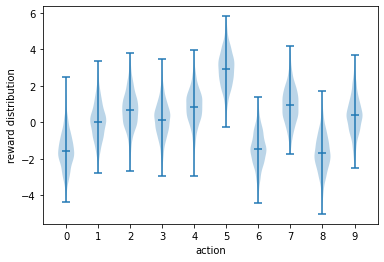

In [51]:
fig, ax = plt.subplots()
ax.violinplot(
    action_rewards,
    np.arange(0, bandit.k),
    showmeans=True,
    showmedians=False,
    showextrema=True
)
ax.set_xlabel('action')
ax.set_xticks(np.arange(0, bandit.k))
ax.set_ylabel('reward distribution')
plt.show()

# Comparison of Standard Algorithms
Your task in this exercise is to compare the bandit algorithms listed below on our standard testbed e.g. the 10-armed bandit problem.
* Iterative Sample Average Method
* Greedy vs. epsilon-Greedy Action Selection
* Optimistic Initial Values
* Upper Confidence Bound Method
* Gradient Bandit Algorithms
* Iterative Sample Average Method with constant step size

## Random Action Selection Baseline
Implementation of a random action selection baseline. This should just serve as a template for you to implement the "much more intelligent" bandit algorithms below.

In [52]:
class RandomBaseline():
    def __init__(self, k=10, seed=None):
        """
        Random Action Selection Baseline
        
        This method simply selects an action at random, and does
        not care about rewards at all.
    
        Parameters
        ----------
            @k: number of possible actions (integer)
            @seed: PRNG seed
        """
        # we should definitely remember how many actions there are
        # in order to make a decision ...
        self.k = k
        
        # all of the random behavior of an agent should depend on a
        # PRNG that is initialized in the constructor, given the seed
        
        # whenever your agent has the need for random numbers,
        # you **must use only this** PRNG!
        self.rng = np.random.default_rng(seed)
    
    def choose_action(self):
        """ Action selection is random """
        # we'll use the PRNG that has been initialized in the constructor
        # to draw a uniformly distributed, random integer from the interval [0, k[
        return self.rng.integers(0, self.k)
    
    def update_estimates(self, action, reward):
        """ Because we behave randomly, we don't need to update anything."""
        pass

## Experimental setup
For comparing the implemented methods, we will create similar <b>time step vs. average reward plots</b> as the ones shown in the lecture slides, and the book.

In order to facilitate this comparison, we will define a convenience function to run experiments. This enables us to specify an `agent_class` together with its parameters `agent_args`, and then run `n_runs` different instances of the k-armed bandit problem for `n_steps` steps, using `agent_class` to solve the problems.

<div class="alert alert-info"> 
**Hint:** for debugging purposes, you may want to run a smaller number of runs, for a smaller number of steps, and you may change the defaults for `n_runs` and `n_steps` here.
    
<b>Please remember to change them back to `n_runs=2000` and `n_steps=1000`, and re-run the entire notebook before submitting!</b>
</div>

In [53]:
def run_experiments(exp_seed,
                    n_runs=2000,
                    n_steps=1000,
                    k=10,
                    bandit_class=kArmedBandit,
                    agent_class=RandomBaseline,
                    agent_args=dict()):
    """
    Run experiments following the policy of the provided agent.
    
    Parameters
    ----------
    @exp_seed: the seed for the 'mother-PRNG' that produces all other seeds
    @n_runs: number of different bandit problems (integer)
             (to debug your algorithms, you may set this to a lower number.
              don't forget to change it back, once you're done with debugging!)
    @n_steps: number of steps taken in each individual problem (integer)
              (to debug your algorithms, you may set this to a lower number.
              don't forget to change it back, once you're done with debugging!)
    @k: number of actions for the bandit problems (integer)
    @bandit_class: this allows you to change the type of bandit
                   (please only do so for the last problem in this problem set)
    @agent_class: specifies the bandit algorithm to use
    @agent_args: this dictionary of arguments will be passed on
                 to the constructor of the specified bandit algorithm,
                 
                 (with the exception of 'k' and 'seed', as these will be set
                 by the experiment loop)
    
    Returns
    -------
    a numpy array of rewards with shape (n_runs, n_steps), where
    element (i,j) contains the reward in the i-th run, on the j-th step
    """
    args_list = [f'{key}={val}' for key, val in sorted(agent_args.items())]
    args_string = ','.join(args_list)
    print("running {}({})".format(agent_class.__name__, args_string))
    
    # initialize results
    rewards = np.zeros((n_runs, n_steps))

    if isinstance(exp_seed, list):
        exp_seed = exp_seed[0]
    
    # if we're getting entropy, initialize new seed sequence
    if isinstance(exp_seed, int):
        exp_seed_sequence = np.random.SeedSequence(exp_seed)
    elif isinstance(exp_seed, np.random.SeedSequence):
        exp_seed_sequence = exp_seed
    else:
        raise ValueError('please provide SeedSequence or int!')
    
    # perform multiple runs
    for run in range(n_runs):
        # split off 2 new seeds, one for the agent, one for the bandit
        agent_seed, bandit_seed = exp_seed_sequence.spawn(2)

        # instantiate agent, pass it its arguments
        agent = agent_class(k=k, seed=agent_seed, **agent_args)
        
        # get new instance of problem, with new seed
        bandit = bandit_class(k=k, seed=bandit_seed)

        # perform multiple steps on problem instance
        for step in range(n_steps):

            # let the agent pick an action according to its selection strategy
            action = agent.choose_action()

            # the bandit is told the action that the agent chose, and gives out a reward
            reward = bandit.step(action)

            # the agent is told what the reward was for choosing the action
            agent.update_estimates(action, reward)

            # we will record all rewards for later analysis
            rewards[run, step] = reward
    
    print("done!")
    return rewards

In [14]:
import numpy as np
xt = np.asarray([[1,1,1,1],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
xx = xt @ x.T

xin = np.linalg.inv(xx)

xx @ xin @ xin
xin

array([[ 1., -1., -1., -1.],
       [-1.,  2.,  1.,  1.],
       [-1.,  1.,  2.,  1.],
       [-1.,  1.,  1.,  2.]])

### Example Experiments, Random Action Selection
Lets see how well our random action selection baseline performs, and run one experiment.

In [54]:
# run experiments
rewards_random = run_experiments(exp_seed=1234, agent_class=RandomBaseline)

running RandomBaseline()
done!


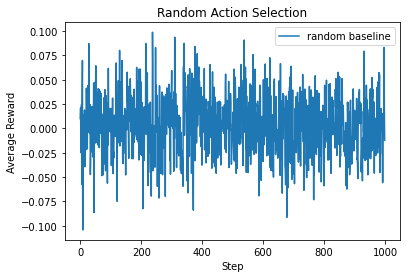

In [55]:
# visualize results
fig, ax = plt.subplots()
ax.plot(
    rewards_random.mean(axis=0),  # average over all runs
    label='random baseline'       # choose a name
)
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
ax.set_title("Random Action Selection")
plt.show()

### Run multiple example experiments, collect results
Let's see how we can run multiple experiments, with different parameters.

In [56]:
# for consecutive experiments, having a so-called 'seed sequence', is
# extremely convenient. also look it up in the documentation, to see
# why this is a "really good idea(tm)"!
exp_seed_sequence = np.random.SeedSequence(4711)

# it's convenient to store the experiments in a
# dictionary, so we can iterate over them more easily later on
all_rewards = dict()
all_rewards['algo A, params X, Y, ...'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=RandomBaseline
)
all_rewards['algo B, params U, V, ...'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=RandomBaseline
)

# (the algorithms in this example have the same parameters
# but b/c they're completely random anyways, it does not matter)

running RandomBaseline()
done!
running RandomBaseline()
done!


### Visualize multiple results in one plot

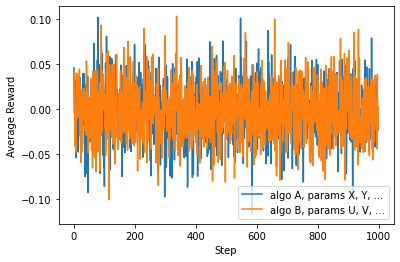

In [57]:
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over axis=0, meaning 'over all runs'
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

---
## 1.1 Incremental Sample Average Method (5 points)
Implementation of the Sample Average Method. The algorithm is parametrized by the number of actions and a probability $\epsilon$ of picking a random action instead of following the policy.

Use the optional parameter `initial_value` to implement the "Optimistic Initial Values" trick, that encourages exploration.

In [58]:
class IncrementalSampleAverageMethod():
    def __init__(self, k=10, epsilon=0.0, initial_value=0.0, seed=None):
        """
        Incremental Implementation of the "Sample Average Method"

        Parameters
        ----------
            @k: number of possible actions (integer)
            @epsilon: probability for selecting a random action (float in the interval [0, 1])
            @initial_value: initial action value estimate (should be used for Optimistic Initial Values)
            @seed: the PRNG seed. the PRNG will help us to decide when to explore and when to exploit
        """
        self.k = k
        self.epsilon = epsilon
        
        # TODO
        self.estimates = np.asarray(k*[initial_value]) # initialize an array with our initial estimates

        
        
        # seed the PRNG
        self.rng = np.random.default_rng(seed)

        self.action_counts = np.zeros(k)
        self.count_action_numbers_list = [0]*k
        
    def choose_action(self):
        """ Action selection """
        # TODO
        random_number = self.rng.uniform()
        if random_number <= epsilon: #select random action
            
            chosen_action = self.rng.integers(0, self.k) # index of a random action
             
        else: # Choose action with highest reward estimate
            chosen_action = np.argmax(self.estimates) # index of the highest value
            
        self.action_counts[chosen_action] += 1
        return chosen_action # number which stands for an action
    
    def update_estimates(self, action, reward):
        """ Update action value estimate """
        # TODO

        
        self.count_action_numbers_list[action] += 1
        
        self.estimates[action] += ((reward-self.estimates[action])/self.count_action_numbers_list[action])
      
        pass

        

## 1.2 Greedy vs. $\epsilon$-Greedy (5 points)
In our first experiment we will explore the influence of the random action selection probability $\epsilon$ on the average reward we get over time.

For this purpose:
- run the *IncrementalSampleAverageMethod* three times with $\epsilon \in \{0.0, 0.01, 0.1\}$.
- collect the rewards that could be achieved for each parametrization, and plot their means in one plot for comparison.
- describe your observations **qualitatively** (describe briefly with some text)

Answer the following questions **quantitatively** (use numbers / formulae to quantify differences):
- which method will perform best in the long run?
  (in terms of cumulative reward and the probability of selecting the optimal action)
- how much better will the best method be than the second best?

In [59]:
# run experiments
exp_seed_sequence = np.random.SeedSequence(4711)
all_rewards_sample_average_method = dict()

for epsilon in [0.0,0.01,0.1]:

    all_rewards_sample_average_method[f'sample_average_method epsilon ={epsilon}'] = run_experiments(exp_seed=exp_seed_sequence,
                    k=10,
                    bandit_class=kArmedBandit,
                    agent_class=IncrementalSampleAverageMethod,#(epsilon=epsilon),
                    agent_args=dict(epsilon=epsilon))

running IncrementalSampleAverageMethod(epsilon=0.0)
done!
running IncrementalSampleAverageMethod(epsilon=0.01)
done!
running IncrementalSampleAverageMethod(epsilon=0.1)
done!


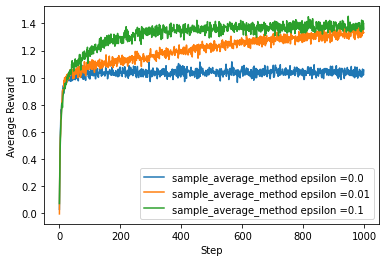

In [60]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards_sample_average_method.items():
    ax.plot(
        rewards.mean(axis=0),  # average over axis=0, meaning 'over all runs'
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

#### Answers
* The more often the agents acts the more precisely we can estimate the reward for each action. Therefore, the agent will choose better actions after more steps. <br>
Furthermore, for $\epsilon$ = 0 (never choose actions randomly and therefore avoiding exploration) we have smaller average rewards because the agent misses to look at alternative actions that are in the greedy view not good at the moment but in long term view could be even better than the maximal reward estimated action.
* method with $\epsilon$ = 0.01 
* 0 (when the the steps go to infinity and by the rule of big numbers estimates of converge for both methods to the true value)


## 1.3 Greedy vs. Optimistic Initial Values (2 points)
In our second experiment we evaluate the performance of another approach to encourage exploration, namely Optimistic Initial Values.

For this purpose
- run *IncrementalSampleAverageMethod* with an initial value of $5$ for all actions
- and compare its performance with the *IncrementalSampleAverageMethod* with initial value of $0$ and $\epsilon=0$
- briefly describe and explain your observations textually

In [61]:
# run experiments
rewards_13 = dict()
exp_seed_sequence = np.random.SeedSequence(4711)

for ini_value in [5.0,0.0]:
    
    rewards_13[f'sample_average_method inital_value={ini_value}'] = run_experiments(exp_seed=exp_seed_sequence,
                    k=10,
                    bandit_class=kArmedBandit,
                    agent_class=IncrementalSampleAverageMethod,
                    agent_args=dict(initial_value=ini_value))


running IncrementalSampleAverageMethod(initial_value=5.0)
done!
running IncrementalSampleAverageMethod(initial_value=0.0)
done!


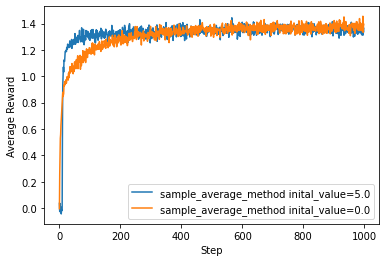

In [62]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in rewards_13.items():
    ax.plot(
        rewards.mean(axis=0),  # average over axis=0, meaning 'over all runs'
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

#### Answers
In beginning the method with initial value=5.0 makes more explorations than the other one. Therefore, it tries out all the actions. However, not all actions are good. Therefore, the method with initial value=5.0 performs worse in the beginning than the other one. However, when all actions are explored the agent gets also an better estimate which actions could be better. Therefore, it performs better than the other method after ca. 10 steps.

## 2.1 Upper Confidence Bound Action Selection (5 points)
Implement the Upper Confidence Bound Action Selection Method. The algorithm is parametrized by the number of actions and a value $c > 0$ to control the degree of exploration.

<div class="alert alert-info">
**Hint:** In case you encounter a division by 0 error, take a closer look at the values for $t$ and $N_t(a)$.
Note that if $N_t(a) = 0$, then $a$ is considererd to be a greedy (maximizing) action.
</div>

In [63]:
class UpperConfidenceBound():
    def __init__(self, k=10, c=0.0, seed=None):
        """
        Upper Confidence Bound Action Selection Method
        
        Parameters
        ----------
            @k: number of possible actions (integer)
            @c: parameter that trades off exploration and exploitation
            @seed: for this algorithm, this does not do anything, but it needs
                   to be there, b/c all other constructors have this ...
        """
        # TODO
        self.k = k
        self.c = c
        self.seed = seed
        
        self.estimates = np.zeros(self.k)
        self.count_action_usages = np.zeros(self.k)
        self.time_counter = 0
        
                
    def choose_action(self):
        """ Action selection """
        # TODO
        
        count_usage_actions_local = np.where(self.count_action_usages == 0)[0]
        
        if len(count_usage_actions_local) != 0: # there is action which was not chosen so far
            UCB_chosen_action = count_usage_actions_local[0]
            
        else: 
            actions = self.estimates + self.c * np.sqrt(np.log(self.time_counter)/self.count_action_usages)
            UCB_chosen_action = np.argmax(actions)


        self.time_counter += 1   

        self.count_action_usages[UCB_chosen_action] += 1
        
        return UCB_chosen_action
    
    def update_estimates(self, action, reward):
        """ Update action value estimate """
        # TODO
        
        self.count_action_usages[action] += 1
        
        self.estimates[action] += ((reward-self.estimates[action])/self.count_action_usages[action])

        pass


## 2.2 $\epsilon$-Greedy vs Upper Confidence Bound Action Selection (2 points)
In our next experiment we compare $\epsilon$-greedy action selection with the *UCB* action selection algorithm.

For this purpose
- run the *UCB* action selection algorithm with exploration parameter $c=2$
- and compare its performance with the *IncrementalSampleAverageMethod* and $\epsilon=0.1$
- briefly describe and explain your observations

In [64]:
# run experiments
rewards_22 = dict()
rewards_22['UCB c=2'] = run_experiments(exp_seed=exp_seed_sequence,
                bandit_class=kArmedBandit,
                agent_class=UpperConfidenceBound,
                agent_args=dict(c=2))


running UpperConfidenceBound(c=2)
done!


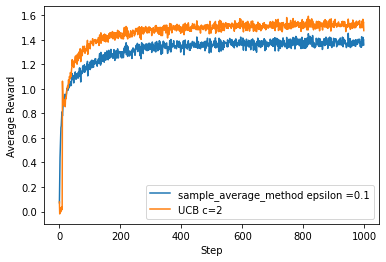

In [65]:
# visualize results
dict_short = dict()
dict_short['sample_average_method epsilon =0.1'] = all_rewards_sample_average_method['sample_average_method epsilon =0.1']
dict_short['UCB c=2'] = rewards_22['UCB c=2'] 

fig, ax = plt.subplots()

for label, rewards in dict_short.items():
    ax.plot(
        rewards.mean(axis=0),  # average over axis=0, meaning 'over all runs'
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

#### Answers
UCB reaches a higher average reward score than the sample average method with epsilon=0.1. It seems like in the UCB it is better regulated, when to explore a new action because it considers how often the agent made use of the new action in an certain amount of time steps. In contrast, the sample average method decides that randomly.

## 2.3 UCB Spikes (3 points)
We will look at the behavior of UCB a bit closer now.

For this purpose
- set `n_runs=2000` and `n_steps=50` for this set of experiments
- run the UCB action selection algorithm with exploration parameters $c=[0, 0.5, 1, 2, 4]$
- describe what you see, and explain the behavior of UCB depending on $c$

In [66]:
# run experiments
rewards_23 = dict()
exp_seed_sequence = np.random.SeedSequence(4711)
for c in [0,0.5,1,2,4]:
    rewards_23[f'UCB c={c}'] = run_experiments(exp_seed=exp_seed_sequence,
                    n_runs=2000,
                    n_steps=50,                          
                    bandit_class=kArmedBandit,
                    agent_class=UpperConfidenceBound,
                    agent_args=dict(c=c))


running UpperConfidenceBound(c=0)
done!
running UpperConfidenceBound(c=0.5)
done!
running UpperConfidenceBound(c=1)
done!
running UpperConfidenceBound(c=2)
done!
running UpperConfidenceBound(c=4)
done!


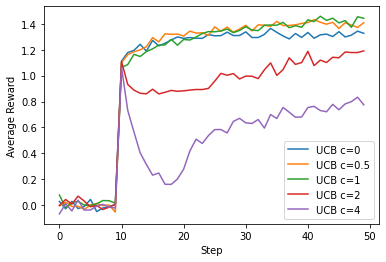

In [67]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in rewards_23.items():
    ax.plot(
        rewards.mean(axis=0),  # average over axis=0, meaning 'over all runs'
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

#### Answers
In the first 10 steps the rewards are rather low because we have 10 actions. All of them have to be visited first. After 10 actions the exploitation can start with the action with the highest score (therefore strong increase in average reward). The UCBs with high c-values 2 and 4 reach in 50 steps lower scores than the other UCBs because they vist more often seldom used actions. In later steps they will catch up the other methods. <br>The UCB with c=0 is purely greedy (always wants to exploit but not explore).

## 3.1 Gradient Bandit Algorithm (5 points)
Implement the Gradient Bandit Algorithm with baseline. The algorithm is parametrized by the number of actions and step size $\alpha$.

In [68]:
class GradientBandit():
    def __init__(self, k=10, alpha=0.1, seed=None):
        """
        Gradient Bandit Action Selection Method

        Parameters
        ----------
            @k: number of possible actions (integer)
            @alpha: step-size parameter, or learn rate (float)
            @seed: the PRNG seed. it'll be used to sample from the softmax distribution.
        """ 
        # TODO
        self.k = k 
        self.alpha = alpha
        self.rng = np.random.default_rng(seed)
        
        dt = np.dtype(np.float64) 

        self.preferences = np.zeros(k, dtype = dt)
        self.softmax_array = None
        
        self.r_a = 0
        self.n_a = 0
    
    def choose_action(self):
        """ Action selection """
        # TODO

        # Make preference/softmax for each action
        self.softmax_array = np.exp(self.preferences)/np.sum(np.exp(self.preferences))
        # get a distribution between 0 and 1

        # Generate random number:
        chosen_action_array = self.rng.multinomial(1, self.softmax_array) # choose one action but also consider
        # the probability distribution of the softmax_array
        
        chosen_action = np.where(chosen_action_array==1)[0][0]

        return chosen_action
    
    def update_estimates(self, action, reward):
        """ update action selection preferences """
        # TODO
        one_hot = np.zeros(self.k)
        one_hot[action] = 1
   
        if self.n_a == 0:
            collected_rewards_average = 0
            
        else:
            collected_rewards_average = self.r_a/self.n_a
            
        pref = self.preferences.copy()
        self.preferences = self.preferences + self.alpha * (reward - collected_rewards_average)*(one_hot - self.softmax_array)

        self.r_a += 1
        self.n_a += 1
        

        pass



## 3.2 $\epsilon$-Greedy vs Gradient Bandit (2 points)
In our last experiment we compare $\epsilon$-greedy action selection with the *GradientBandit* algorithm.

For this purpose
- run the *GradientBandit* algorithm with step sizes $\alpha=0.01$ and $0.1$.
- and compare its performance with the *IncrementalSampleAverageMethod* and $\epsilon=0.1$.
- briefly describe and explain your observations.

In [69]:
# run experiments
rewards_32 = dict()
exp_seed_sequence = np.random.SeedSequence(4711)

for a in [0.01, 0.1]:
    
    rewards_32[f'GradientBandit alpha={a}'] = run_experiments(exp_seed=exp_seed_sequence,                          
                    bandit_class=kArmedBandit,
                    agent_class=GradientBandit,
                    agent_args=dict(alpha=a))


running GradientBandit(alpha=0.01)
done!
running GradientBandit(alpha=0.1)
done!


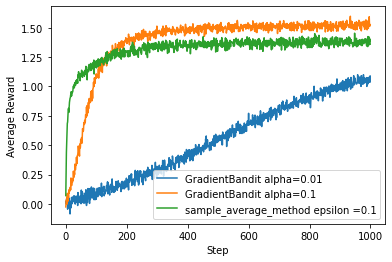

In [70]:
# visualize results
rewards_32['sample_average_method epsilon =0.1'] = all_rewards_sample_average_method['sample_average_method epsilon =0.1']

fig, ax = plt.subplots()

for label, rewards in rewards_32.items():
    ax.plot(
        rewards.mean(axis=0),  # average over axis=0, meaning 'over all runs'
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

#### Answers
With a correct chosen $\alpha$ the Gradient Bandit Algorithm can outperform the sample average method because it adapts in each steps all action preferences strategically whereas the sample average method rests on randomness. <br>
With larger step-size $\alpha$ the Gradient Bandit Algorithm reaches faster high average rewards. When $\alpha$ is small the algorithm only makes small adaptions to estimate Q. 

# 4. Tracking non-stationary problems (5 points)
Sample-average methods have difficulties with <b>non-stationary</b> problems. We will use a <b>modified</b> version of the 10-armed bandit, in which all the $q_{\star}(a)$ start out equal and then take independent random walks. This is implemented already below, and you just need to create a <b>modified version</b> of the Incremental Sample Average Method that is able to deal with non-stationary problems.

You will need to run separate experiments for:
- an action-value method using sample averages, incrementally computed by $\alpha=\frac{1}{n}$ (you have that already)
- another action-value method that uses a constant step-size parameter, $\alpha=0.1$ (you still need to create that)

Use an $\epsilon=0.1$ for both methods, and then briefly describe the behavior of the two algorithms.

(this is very similar to Exercise 2.5 from the book)

In [71]:
class NonstationaryKArmedBandit():
    def __init__(self, k=10, seed=None):
        self.k = k
        self.rng = np.random.default_rng(seed)
        # for the non-stationary bandit problem, all true action
        # values will start out equal
        self.q_star = np.zeros(k)
    
    def step(self, action):
        self.q_star += self.rng.normal(0, 0.01, self.k)
        Rt = self.rng.normal(self.q_star[action], 1)
        return Rt

In [72]:
class ISAM_cs():
    def __init__(self, k=10, epsilon=0.0, initial_value=0.0, alpha=0.1, seed=None):
        # TODO
        
        self.k  = k
        self.epsilon = epsilon
        self.estimates = np.asarray(k*[initial_value])
        self.alpha = alpha
        self.rng = np.random.default_rng(seed)
        
        self.collected_alpha_rewards_array = None
        
        self.count_action_numbers_list = [0]*k
        
    def choose_action(self):
        # TODO
        
        random_number = self.rng.uniform()
        
        if random_number <= epsilon: #select random action
            chosen_action = self.rng.integers(0, self.k) # index of a random action # k gets excluded 
             
        else: # Choose action with highest reward estimate
            chosen_action = np.argmax(self.estimates) # index of the highest value

        return chosen_action # number which stands for an action
    
    def update_estimates(self, action, reward):
        # TODO
 
        
        self.estimates[action] += self.alpha * (reward-self.estimates[action])    
        
            
        pass    

In [73]:
# run experiments
rewards_4 = dict()
exp_seed_sequence = np.random.SeedSequence(4711)

rewards_4[f'ISAM_cs alpha=0.1, epsilon=0.1'] = run_experiments(exp_seed=exp_seed_sequence,                          
                bandit_class=NonstationaryKArmedBandit,
                agent_class=ISAM_cs,
                agent_args=dict(alpha=0.1, epsilon=0.1))

rewards_4['sample_average_method epsilon =0.1'] = run_experiments(exp_seed=exp_seed_sequence,                          
                bandit_class=NonstationaryKArmedBandit,
                agent_class=IncrementalSampleAverageMethod,
                agent_args=dict(epsilon=0.1))

running ISAM_cs(alpha=0.1,epsilon=0.1)
done!
running IncrementalSampleAverageMethod(epsilon=0.1)
done!


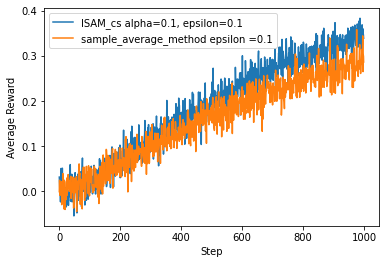

In [74]:
# visualize results

fig, ax = plt.subplots()

for label, rewards in rewards_4.items():
    ax.plot(
        rewards.mean(axis=0),  # average over axis=0, meaning 'over all runs'
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

#### Answers
Using a fixed step size $\alpha$ leads to a higher average reward score because in the sample average method with varying step size the rewards get less impact on the updating estimates the more often they were used, whereas by using a constant step size $\alpha$ the new added updates have always the same impact on the final estimates. The reason is, that the agent should consider recent happenings in the action environment relation in non-stationary problems. With an fixed $\alpha$ that works better.

Remark UE: for environment no seed set. only used random number instances. Query the operating system, ask operating system for a string of random bytes which comes from real world like mircrophone/camera. <br><br>
For all runs we don't get same execution phase, random. 

As 2 Notes: fishlake.py: contains the environment implementation. <br>
reset only important in as. 3. Get back to start state as agent.<br>
step function takes action which returns info if problem ended. as. 2 ignore dict <br>
